In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image
from pathlib import Path
from glob import glob
import pandas as pd
from tqdm import tqdm
import os
from  sklearn.metrics import pairwise_distances

In [217]:
def show_cities(lines):
    plt.figure(figsize=(8,12));plt.axis('off')
    plt.scatter(lines[:, 1], lines[:, 0])
    
def plot_path(positions, solution, pre_title=''):
    
    plt.title(f"{pre_title} {get_path_distance(solution, distance):0.0f}")
    plt.scatter(positions[:, 1], positions[:, 0])
    
    for idx in range(len(solution)):    
        pt1 = solution[idx]
        pt2 = solution[idx+1] if idx+1 != len(solution) else solution[0]
        st  = positions[pt1]
        end = positions[pt2]
        plt.plot([st[1], end[1]], [st[0], end[0]], 'r')
        
def get_path_distance(solution, distance):
    sum_dist = 0
    for idx in (solution):
        start  = solution[idx]
        if idx+1 == len(solution):
            end = solution[0]
        else:
            end    = solution[idx+1]
        sum_dist += distance[start, end]
    return sum_dist

def get_children(solution):    
    children = []
    for idx in range(len(solution)-1):
        temp = solution.copy()
        temp[idx], temp[idx+1] = temp[idx+1], temp[idx]
        children.append(temp)
    temp = solution.copy()
    temp[idx], temp[0] = temp[0], temp[idx]
    children.append(temp)
    return children

def get_best_child(solution, distance):
    children = -1
    best_dist = 9e20
    for idx in range(len(solution)-1):
        temp = solution.copy()
        temp[idx], temp[idx+1] = temp[idx+1], temp[idx]
        dist = get_path_distance(temp, distance)
        if dist < best_dist:
            children = temp
            best_dist = dist
    
    temp = solution.copy()
    temp[idx], temp[0] = temp[0], temp[idx]
    dist = get_path_distance(temp, distance)
    if dist < best_dist:
        children = temp
        best_dist = dist    
    
    return children, best_dist

def get_best_child_r(solution, distance):
    children  = -1
    best_dist = 9e20
    len_sol   = len(solution) 
    for idx in range(len_sol):
        ridx  = np.random.randint(len_sol)
        temp  = solution.copy()
        temp[idx], temp[ridx] = temp[ridx], temp[idx]
        dist = get_path_distance(temp, distance)
        if dist < best_dist:
            children = temp
            best_dist = dist

    
    return children, best_dist

In [218]:
countrie = ["Qatar", "qa194"] # Optimal tour has length 9352.
countrie = ["Djibouti", "dj38"] # Optimal tour has length 6656.
save_path = f"extra/{countrie[0]}"
data_path = f"{save_path}/data.tsv"
Path(save_path).mkdir(exist_ok=True, parents=True)

In [219]:
if not Path(data_path).exists():
    cmd = f"wget http://www.math.uwaterloo.ca/tsp/world/{countrie[1]}.tsp -O {data_path}"
    os.system(cmd)

In [220]:
with open(data_path, "r") as f:
    lines = f.readlines()
lines = map(lambda x: x.replace('\n', ''), lines)
lines = list(filter(lambda x: x.split(" ")[0].isnumeric(), list(lines)));
lines = list(map(lambda x: list(map(lambda y: float(y), x.split(" ")))[1:], lines))
positions = np.array(lines)

num_cities       = len(lines)
initial_solution = list(range(num_cities))


Xmin = positions[:, 0].min()
Ymin = positions[:, 1].min()

#positions[:, 0] -= Xmin
#positions[:, 1] -= Ymin

Xmax = positions[:, 0].max()
Ymax = positions[:, 1].max()

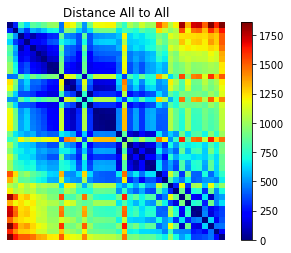

In [221]:
distance = pairwise_distances(positions)

plt.title("Distance All to All")
plt.imshow(distance, cmap='jet')
plt.colorbar();plt.axis('off');

In [243]:
def hill_climber(positions, distance, use_random=True, rseed=10):
    actual = np.array((range(num_cities)))
    #np.random.seed(rseed)
    np.random.shuffle(actual)
    dist = get_path_distance(actual, distance)
    t = (range(10_000))
    for idx in t:
        if use_random:
            child, child_dist = get_best_child_r(actual, distance)
        else:
            child, child_dist = get_best_child(actual, distance)
        if child_dist < dist:
            dist = child_dist
            actual = child
        else:
            break
        #t.set_description(f"Dist {dist:0.0f}")
        
    return actual, dist

In [244]:
actual_r, dist_r = -1, 9999999999
t = tqdm(range(1000))
for idx in t:
    new, new_dist = hill_climber(positions, distance, use_random=True, rseed=idx)
    if new_dist < dist_r:
        actual_r = new
        dist_r = new_dist
         
    t.set_description(f"Dist {dist:0.0f}")

Dist 9472: 100%|██████████| 1000/1000 [01:34<00:00, 10.56it/s]


In [245]:
actual, dist = -1, 9999999999
t = tqdm(range(1000))
for idx in t:
    new, new_dist = hill_climber(positions, distance, use_random=False, rseed=idx)
    if new_dist < dist:
        actual = new
        dist = new_dist
         
    t.set_description(f"Dist {dist:0.0f}")

Dist 16512: 100%|██████████| 1000/1000 [01:17<00:00, 12.98it/s]


In [246]:
started = np.array(list(range((num_cities))))
shuffle = np.array(list(range((num_cities))))
np.random.shuffle(shuffle)

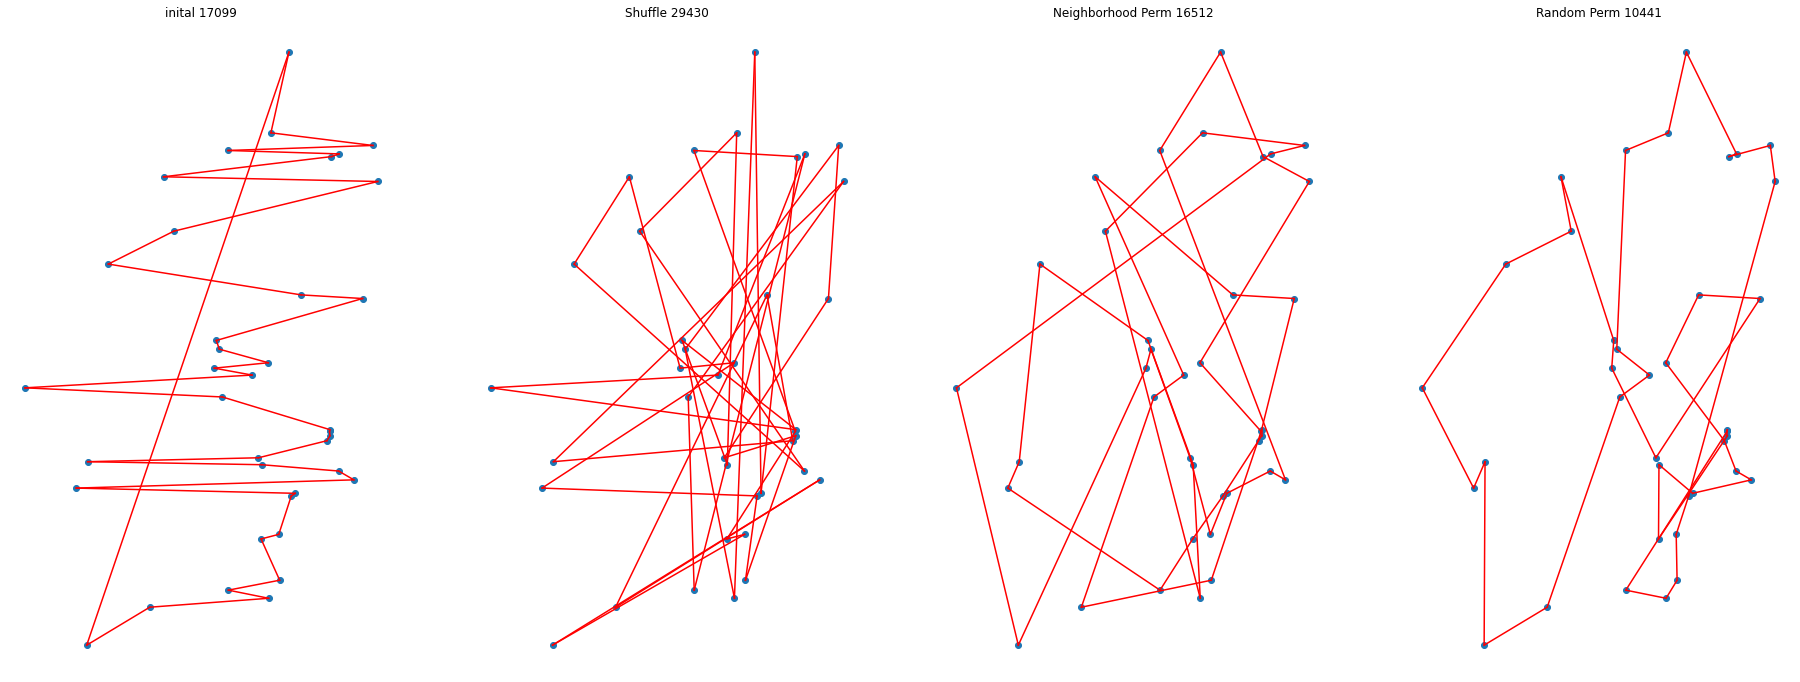

In [250]:
plt.figure(figsize=(8*4,12))
plt.subplot(141);plt.axis('off')
plot_path(positions, initial_solution, "inital")
plt.subplot(142);plt.axis('off')
plot_path(positions, shuffle, "Shuffle")
plt.subplot(143);plt.axis('off')
plot_path(positions, actual, "Neighborhood Perm")
plt.subplot(144);plt.axis('off')
plot_path(positions, actual_r, "Random Perm")
plt.savefig(f"{save_path}/summary.png")